Este projeto foi uma atividade de Finanças do curso de Ciencia de Dados. 
E para a elabroação da fronteira eficiente foi realizado os procedimentos abaixo:

1. Ler as bases de preços diários
2. Calcular retornos relativos diários (HP=1)
3. Calcular retorno médio e desvio padrão de cada ativo
4. Calcular matriz de covariância dos ativos
5. Plotar os ativos num gráfico de dispersão: retorno x risco
6. Definir pesos para os ativos e compor em uma carteira. Calcular o retorno e o risco desta carteira
7. Simular diversos conjuntos de pesos aleatoriamente e plotar no gráfico de dispersão estas carteiras

In [1]:
# Bibliotecas
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.linear_model import LinearRegression
import scipy.optimize as solver

In [2]:
# Ler e tratar as bases
def read_infoMoney(file_name:dict):
    # função que lê um dicionario com os ativos e os respectivo csv
    
    df = pd.DataFrame()
    
    
    for key, value in file_name.items():
        df_import = pd.read_csv(f'Bases/{value}')
                
        df_import = df_import[::-1]
        
        df[key] = df_import['FECHAMENTO']
        
        # os valores no csv estão no formato brasileiro de decimais
        # aplicando função apply e lambda para conversão em float
        df[key] = df[key].apply(lambda x: float(str(x).replace(',', '.')))
        
        
    
    # retorna o dataframe com os ativos
    return df.reset_index(drop = True)

In [3]:
# Dicionário de ativos
assets = {
      'IBOV': 'Ibovespa (IBOV) - Histórico  InfoMoney.csv',  
      'ABEV3': 'Ambev SA ABEV3 - Histórico InfoMoney.csv',
      'PETR3': 'Petrobras PETR3 - Histórico InfoMoney.csv',
      'MGLU3': 'Magazine Luiza MGLU3 - Histórico InfoMoney.csv',
      'ITUB3': 'Itaú Unibanco ITUB3 - Histórico InfoMoney.csv',
      'ALPA3': 'Alpargatas ALPA3 - Histórico InfoMoney.csv',
      'VALE3': 'Vale S.A. VALE3 - Histórico InfoMoney.csv'}

assets

{'IBOV': 'Ibovespa (IBOV) - Histórico  InfoMoney.csv',
 'ABEV3': 'Ambev SA ABEV3 - Histórico InfoMoney.csv',
 'PETR3': 'Petrobras PETR3 - Histórico InfoMoney.csv',
 'MGLU3': 'Magazine Luiza MGLU3 - Histórico InfoMoney.csv',
 'ITUB3': 'Itaú Unibanco ITUB3 - Histórico InfoMoney.csv',
 'ALPA3': 'Alpargatas ALPA3 - Histórico InfoMoney.csv',
 'VALE3': 'Vale S.A. VALE3 - Histórico InfoMoney.csv'}

In [4]:
empresas = read_infoMoney(assets)
empresas

,IBOV,ABEV3,PETR3,MGLU3,ITUB3,ALPA3,VALE3
0,77.891,19.04,13.99,2.47,16.99,NaN,31.98
1,77.995,19.11,14.10,2.42,17.11,NaN,32.48
2,79.071,19.08,14.32,2.42,17.01,NaN,33.20
3,79.379,19.02,14.32,2.36,16.77,NaN,33.08
4,78.864,19.02,14.05,2.39,16.83,NaN,32.62
...,...,...,...,...,...,...,...
238,85.269,13.83,19.24,5.50,20.35,20.03,39.81
239,85.697,13.80,19.26,5.65,20.01,20.03,40.65
240,85.136,13.77,19.62,5.46,19.81,20.69,40.31
241,85.460,13.73,19.51,5.38,20.14,19.66,39.56


In [5]:
# removendo valores nulos
empresas.dropna(inplace = True)
empresas.reset_index(drop = True,inplace = True)
empresas

,IBOV,ABEV3,PETR3,MGLU3,ITUB3,ALPA3,VALE3
0,86.935,19.63,18.27,2.82,19.78,20.42,36.35
1,85.354,19.44,18.30,2.81,19.38,20.48,34.60
2,85.378,19.74,18.00,2.84,19.52,20.38,34.14
3,85.761,19.95,18.32,2.86,19.84,20.43,33.60
4,86.023,19.90,18.84,2.78,20.15,20.73,33.56
...,...,...,...,...,...,...,...
203,85.269,13.83,19.24,5.50,20.35,20.03,39.81
204,85.697,13.80,19.26,5.65,20.01,20.03,40.65
205,85.136,13.77,19.62,5.46,19.81,20.69,40.31
206,85.460,13.73,19.51,5.38,20.14,19.66,39.56


In [6]:
empresas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IBOV    208 non-null    float64
 1   ABEV3   208 non-null    float64
 2   PETR3   208 non-null    float64
 3   MGLU3   208 non-null    float64
 4   ITUB3   208 non-null    float64
 5   ALPA3   208 non-null    float64
 6   VALE3   208 non-null    float64
dtypes: float64(7)
memory usage: 11.5 KB


In [7]:
# Calcular retornos
def calc_return(df, hp):
    # calcula os retonos dos ativos em um dataframe conforme hp indicado
    
    df_returns = pd.DataFrame()
    
    for empresa in df.columns:
        
        df_returns[empresa] = (df[empresa]/df[empresa].shift(hp) - 1) # Retorno
    
    df_returns.dropna(inplace = True)
    
    # retorna novo DF com os retornos diarios
    return df_returns


In [8]:
empresas_ret = calc_return(empresas, 1)
empresas_ret

,IBOV,ABEV3,PETR3,MGLU3,ITUB3,ALPA3,VALE3
1,-0.018186,-0.009679,0.001642,-0.003546,-0.020222,0.002938,-0.048143
2,0.000281,0.015432,-0.016393,0.010676,0.007224,-0.004883,-0.013295
3,0.004486,0.010638,0.017778,0.007042,0.016393,0.002453,-0.015817
4,0.003055,-0.002506,0.028384,-0.027972,0.015625,0.014684,-0.001190
5,-0.004301,0.011055,-0.006369,-0.010791,0.001489,-0.036179,-0.004768
...,...,...,...,...,...,...,...
203,-0.004727,-0.012848,-0.024341,0.005484,0.003947,0.018820,-0.004003
204,0.005019,-0.002169,0.001040,0.027273,-0.016708,0.000000,0.021100
205,-0.006546,-0.002174,0.018692,-0.033628,-0.009995,0.032951,-0.008364
206,0.003806,-0.002905,-0.005607,-0.014652,0.016658,-0.049783,-0.018606


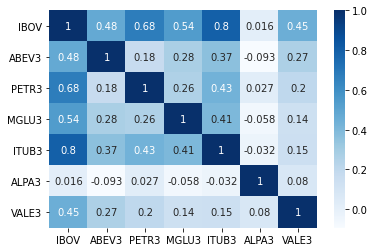

In [9]:
# Cálculo da correlação entre os ativos
correl_matrix = empresas_ret.corr()
sns.heatmap(correl_matrix, annot = True, cmap="Blues");

In [10]:
cov_matrix = empresas_ret.cov() * 252
cov_matrix

,IBOV,ABEV3,PETR3,MGLU3,ITUB3,ALPA3,VALE3
IBOV,0.050340,0.024193,0.076920,0.057935,0.047202,0.001588,0.033324
ABEV3,0.024193,0.050683,0.020312,0.029585,0.021739,-0.009460,0.019843
PETR3,0.076920,0.020312,0.254711,0.062489,0.057612,0.006173,0.033772
MGLU3,0.057935,0.029585,0.062489,0.228197,0.051104,-0.012613,0.021758
ITUB3,0.047202,0.021739,0.057612,0.051104,0.069470,-0.003852,0.012945
ALPA3,0.001588,-0.009460,0.006173,-0.012613,-0.003852,0.203748,0.011869
VALE3,0.033324,0.019843,0.033772,0.021758,0.012945,0.011869,0.108541


In [11]:
# Cálculo do retorno e desvio padrão dos ativos

# retorno medio
mi =  empresas_ret.mean(axis = 0) * 252

# desvio padrao
sigma =  empresas_ret.std(axis = 0) * np.sqrt(252)
mi

IBOV     0.038294
ABEV3   -0.386735
PETR3    0.255791
MGLU3    0.946563
ITUB3    0.079153
ALPA3    0.085408
VALE3    0.193721
dtype: float64

In [12]:
def calc_retorno_port(w,ret):
    # calcula retorno da carteira conforme os pesos
        
    return  (w* ret).sum()

def calc_risco_port(perc, matriz_cov):
    # calculo risco do portfolio conforme os pesos e matriz de covarianca
    
    return np.sqrt(np.dot(perc.T, (np.dot(matriz_cov, perc))))

In [13]:
# Cálculo de retorno e risco da carteira

# pesos carteira
carteira_perc = np.array([1/len(mi.drop('IBOV', axis = 0))]* len(mi.drop('IBOV', axis = 0)))
cov_matrix_port = cov_matrix.drop('IBOV').drop('IBOV', axis = 1)

#carteira_perc = np.array([0.0, 0.0, 1, 0.0, 0.0, 0.0])

# retorno do portfólio
mi_P = calc_retorno_port(carteira_perc, mi.drop('IBOV', axis = 0))

# risco do portfólio
sigma_P = calc_risco_port(carteira_perc, cov_matrix_port)

print(f'Retorno esperado: {round(mi_P*100, 4)}%, risco: {round(sigma_P*100, 4)}%')

Retorno esperado: 19.565%, risco: 20.8293%


In [14]:
# criando uma lista com as colunas do DF e adicionando risco, retorno e indice sharpe
colunas = [x for x in empresas_ret.columns[1:]]
lista = ['Retorno P %', 'Risco %', 'Indice Sharpe']
colunas.extend(lista)
colunas

['ABEV3',
 'PETR3',
 'MGLU3',
 'ITUB3',
 'ALPA3',
 'VALE3',
 'Retorno P %',
 'Risco %',
 'Indice Sharpe']

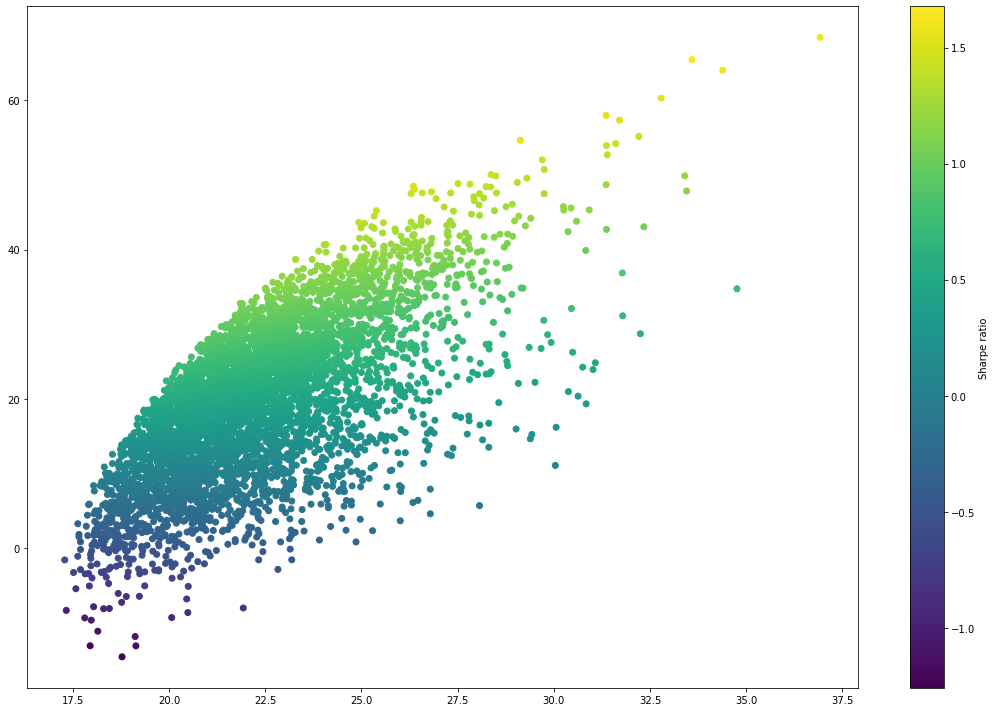

In [15]:
# Simulando carteiras com pesos diferentes

simulacao = pd.DataFrame(columns=[colunas])

# taxa selic de 2015 a 2022 para o indice sharpe
taxa_selic = [12.75, 14.25, 12.25,6.5, 5.0, 2.0, 9.25, 10.75]
taxa_s_risco = np.mean(taxa_selic)

N = 5000

for x in range (N):
    
    np.random.seed(x)
    
    # pesos aleatorios e normalizando
    perc = np.random.random(6)
    perc = np.array(perc/perc.sum())
    
    # calculo do retorno com o pesos aleatório
    ret_P = calc_retorno_port(perc,mi.drop('IBOV', axis = 0) )*100
    
    # risco com os pesos aletórios
    sigma_P = np.sqrt(np.dot(perc.T, (np.dot(cov_matrix_port, perc))))*100
    
    # indice sharpe
    indice_s = (ret_P -taxa_s_risco) / sigma_P
   
    # adicionando os pesos e os valores dos calculos ao DF
    simulacao.loc[x] = [round(perc[0], 3), round(perc[1],3), round(perc[2],3),round(perc[3],3),round(perc[4],3), round(perc[5],3), round(ret_P,2), round(sigma_P,2), round(indice_s, 4)]

    
# Gráfico
plt.figure(figsize= (15,10))
plt.scatter(simulacao['Risco %'], simulacao['Retorno P %'], c = simulacao['Indice Sharpe'])
plt.colorbar(label = 'Sharpe ratio')
#plt.legend(bbox_to_anchor=(1.3, 0.6)) 
plt.tight_layout()   

## Otimização de portfólio

Todo processo de otimização necessita da elaboração de uma função objetiva e da definição de um conjunto de restrições (se houver). Por exemplo, podemos minimizar uma função custo ou maximizar uma função de lucro. No nosso caso, utilizando a teoria de portfólio de Markowitz, desejamos uma das duas coisas:
- minimizar a volatilidade da carteira ou
- maximizar os retornos esperados

Analisaremos adiante cada um dos casos.

### Minimizar a volatilidade

Neste caso, desejamos obter um conjunto de pesos para os ativos da análise, tais que o risco da carteira ponderada por estes pesos seja o menor possível. Podemos escrever este objetivo da seguinte forma:

$$ min F(w) = \sqrt{\sum_{i=1}^N \sum_{j=1}^N W_i \cdot W_j \cdot COV_{i,j}} $$

Contudo, devemos considerar nossas restrições. A primeira delas refere-se aos valores dos pesos. Por definição, estes devem sempre somar 1. Portanto:

$$\sum_{i=1}^N W_i = 1 $$

ou

$$\sum_{i=1}^N W_i - 1 = 0 $$

A segunda restrição refere-se ao retorno desejado para a carteira, $\mu$. Para que este objetivo seja alcançado, podemos definir:

$$\sum_{i=1}^N W_i r_i = \mu $$

ou

$$\sum_{i=1}^N W_i r_i - \mu = 0 $$

Por fim, precisamos que os pesos possuam valores positivos e sejam menores que 100\%:

$$ w_i >= 0, \forall i=1,...,n $$
$$ w_i <= 1, \forall i=1,...,n $$

O que o cálculo numérico realiza é uma busca para encontrar o melhor conjunto de pesos para cada ativo que garanta que as restrições são respeitadas e que se tenha o menor risco possível.

---

Biblioteca Python utilizada para otimização:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

---


In [16]:
# Definindo função objetivo
def f_obj_min_risk(w):
    return np.sqrt(np.dot(w, np.dot(cov_matrix, w)))

# Definindo valor inicial
w_ini = np.array([1/len(mi)]* len(mi)) 


In [17]:
# Definindo o retorno desejado
ret = 0.004

# Definindo restrições
constraints = [{'type': 'eq', 'fun': lambda x: sum(x) - 1}, # primeira restrição
               {'type': 'eq', 'fun': lambda x: sum(x*mi) - ret}] # segunda restrição

# Definindo limites para os pesos
bounds = tuple((0, 1) for x in range(len(w_ini))) 


In [18]:
result = solver.minimize(f_obj_min_risk, w_ini, constraints=constraints, bounds=bounds, 
                         method='SLSQP')
result

     fun: 0.17354673380586172
     jac: array([0.17562206, 0.15052963, 0.19152456, 0.22904363, 0.17781292,
       0.17803364, 0.18527937])
 message: 'Optimization terminated successfully'
    nfev: 96
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([0.00247056, 0.32397647, 0.        , 0.06343235, 0.27141912,
       0.16564376, 0.17305773])

In [19]:
pesos = [round(w*100, 2) for w in result.x]
print(f'Pesos (%): {pesos}\nRisco portfólio (%): {round(result.fun*100,2)}')

Pesos (%): [0.25, 32.4, 0.0, 6.34, 27.14, 16.56, 17.31]
Risco portfólio (%): 17.35


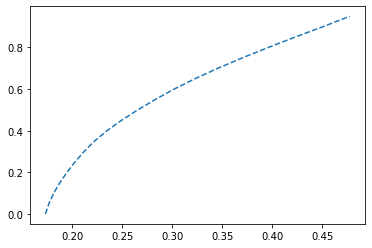

In [20]:
# Simulando para diversos retornos (buscando a fronteira eficiente)
ret_range = np.arange(0.0, 1., 0.05)
sigma_sim = []

for ret in ret_range:
    constraints = [{'type': 'eq', 'fun': lambda x: sum(x) - 1}, # primeira restrição
                   {'type': 'eq', 'fun': lambda x: sum(x*mi) - ret}] # segunda restrição
    
    result = solver.minimize(f_obj_min_risk, w_ini, constraints=constraints, bounds=bounds, 
                         method='SLSQP')
    sigma_sim.append(result.fun)
    
plt.plot(sigma_sim, ret_range, '--')

### Maximizar o retorno
Neste caso, fixamos a volatilidade desejada $\sigma_P$ e definimos a função objetivo para ampliar os retornos calculados a partir dos pesos. O problema de otimização pode ser rezumido por:

$$ max F(w) = \sum_{i=1}^N W_i r_i $$

Sujeito a:

$$\sqrt{\sum_{i=1}^N \sum_{j=1}^N W_i \cdot W_j \cdot COV_{i,j}} = \sigma_P $$
$$\sum_{i=1}^N W_i - 1 = 0 $$
$$ w_i >= 0, \forall i=1,...,n $$
$$ w_i <= 1, \forall i=1,...,n $$

Nas bibliotecas existentes, os problemas de otimização sempre são descritas como minimização. Mas isto não é um problema, pois podemos simplesmente inverter o sinal da função objetivo:

$$ min F(w) = - \sum_{i=1}^N W_i r_i $$

In [21]:
# Definindo função objetivo

def calc_retorno_port2(w):
    
    return  -(sum(w*mi.drop('IBOV', axis = 0)))
    
# Definindo valor inicial
w_ini = np.array([1/len(mi.drop('IBOV', axis = 0))]* len(mi.drop('IBOV', axis = 0)))



risk =  0.015

# Definindo restrições
constraints = [{'type': 'eq', 'fun': lambda x: sum(x) - 1}, # primeira restrição
               {'type': 'eq', 'fun': lambda x: np.sqrt(np.dot(x, np.dot(cov_matrix_port, x))) - risk}] # segunda restrição


# Definindo limites para os pesos
bounds = tuple((0, 1) for x in range(len(w_ini)))


In [22]:
# Imprime resultado
result = solver.minimize(calc_retorno_port2, w_ini, constraints=constraints, bounds=bounds, 
                         method='SLSQP')
result

     fun: 0.09797749303489699
     jac: array([ 0.38673502, -0.25579084, -0.94656305, -0.07915287, -0.0854078 ,
       -0.19372062])
 message: 'Positive directional derivative for linesearch'
    nfev: 855
     nit: 68
    njev: 64
  status: 8
 success: False
       x: array([4.32800870e-01, 1.52089940e-15, 8.80336573e-03, 2.59703188e-01,
       1.60187361e-01, 1.38505216e-01])

In [23]:
pesos = [round(w*100, 2) for w in result.x]
print(f'Pesos (%): {pesos}\nRetorno portfólio (%): {round(result.fun*100 ,2)} ')

Pesos (%): [43.28, 0.0, 0.88, 25.97, 16.02, 13.85]
Retorno portfólio (%): 9.8 


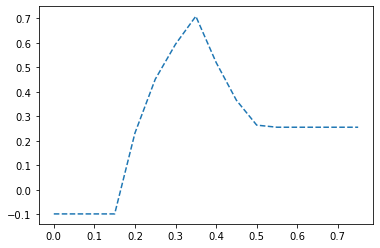

In [24]:
# Simulando para diversos riscos (buscando a fronteira eficiente)
sigma_range = np.arange(0.0, 0.8, 0.05)
retornos = []

for risk in sigma_range:
    constraints = [{'type': 'eq', 'fun': lambda x: sum(x) - 1}, # primeira restrição
                   {'type': 'eq', 'fun': lambda x: np.sqrt(np.dot(x, np.dot(cov_matrix_port, x))) - risk}] # segunda restrição
    
    result = solver.minimize(calc_retorno_port2, w_ini, constraints=constraints, bounds=bounds, 
                         method='SLSQP')
    retornos.append(-result.fun)
    
plt.plot(sigma_range,  retornos, '--')

Uma forma interessante de otimizar foi utilizando o algoritmo simulated_annealing da biblioteca mlrose, e se utilizando de uma função para calcular o indice sharpe e maximizando este.

In [64]:
!pip install mlrose

In [185]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose

In [186]:
def calc_sharpe_ratio (w):
    
    ret_P = calc_retorno_port(w,mi.drop('IBOV', axis = 0) )*100
    
    # risco com os pesos aletórios
    sigma_P = np.sqrt(np.dot(w.T, (np.dot(cov_matrix_port, w))))*100
    
    
    return (ret_P -(taxa_s_risco/100)) / sigma_P

fitness = mlrose.CustomFitness(calc_sharpe_ratio)
maximizacao = mlrose.ContinuousOpt(length =6, fitness_fn = fitness,maximize= True, min_val = 0, max_val = 1)


melhor_solucao, _ = mlrose.simulated_annealing(maximizacao, random_state = 11)
melhor_solucao = melhor_solucao/ melhor_solucao.sum()
print('\nPesos:', melhor_solucao, )


Pesos: [0.         0.         0.77777778 0.         0.11111111 0.11111111]


In [187]:
# retorno do portfólio
mi_P = calc_retorno_port(melhor_solucao, mi.drop('IBOV', axis = 0))

# risco do portfólio
sigma_P = calc_risco_port(melhor_solucao, cov_matrix_port)

print(f'Retorno esperado: {round(mi_P*100, 4)}%, risco: {round(sigma_P*100, 4)}%')

Retorno esperado: 76.723%, risco: 37.9176%


Vamos comparar este resultado do mlrose com o resultado do solver e colocar o mesmo risco

In [28]:
risk = 0.379
constraints = [{'type': 'eq', 'fun': lambda x: sum(x) - 1}, # primeira restrição
                   {'type': 'eq', 'fun': lambda x: np.sqrt(np.dot(x, np.dot(cov_matrix_port, x))) - risk}] # segunda restrição
    

result = solver.minimize(calc_retorno_port2, w_ini, constraints=constraints, bounds=bounds, 
                         method='SLSQP')
result

     fun: -0.7671067635872145
     jac: array([ 0.38673501, -0.25579084, -0.94656305, -0.07915287, -0.0854078 ,
       -0.19372062])
 message: 'Optimization terminated successfully'
    nfev: 127
     nit: 17
    njev: 17
  status: 0
 success: True
       x: array([0.00000000e+00, 7.45416981e-17, 7.75243066e-01, 3.86796995e-17,
       9.46308134e-02, 1.30126120e-01])

In [29]:
pesos = [round(w*100, 2) for w in result.x]
print(f'Pesos (%): {pesos}\nRetorno portfólio (%): {round(-result.fun*100 ,2)} ')

Pesos (%): [0.0, 0.0, 77.52, 0.0, 9.46, 13.01]
Retorno portfólio (%): 76.71 


Ambos chegaram em valores praticamente iguais utilizando-se pesos semelhantes para os mesmos ativos. Mas, cada um apresenta um posto de vista diferente: o solver se utiliza de um valor de restrição de retorno ou risco visando maximizar/minimizar,ou seja, é assumido a qual valor se está disposto; o mlrose utilizamos a maximização do indice sharpe (o quanto o retorno compensa em relaçao ao risco) onde almeja um valor acima de 0.5, mas podemos utilizar-se de outro índice para maximizar ou minimizar seu valor.